In [1]:
import pandas as pd
import numpy as np
import math
import gc
import os

# Data Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Manipulation
from collections import defaultdict

# Vision
from PIL import UnidentifiedImageError, Image, ImageFilter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image

# Model
from tqdm import tqdm  # para mostrar progreso
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset

# Order pictures
import os
import shutil

# Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

device = 'mps'

##  1. Data Cleaning for Training

### 1.1 Load CSV files containing the labels

In [2]:
# File to save training log
loss_txt_file_name = '2.0_loss_logs.txt' 

# Path to dataset folder
data_path = "/Users/marcosbeliera/Desktop/marcos-projects/01.challenges-interviews/challenge-rootstrap/2daa3ac1-1d6b-441d-ab21-6e4e06fe22a5/data"

# Load CSV files containing multilabel class annotations
df_train_labels = pd.read_csv("data/train/_classes.csv", sep=',')
df_val_labels = pd.read_csv("data/valid/_classes.csv", sep=',')
df_test_labels = pd.read_csv("data/test/_classes.csv", sep=',')

# Create copies to be used in dataset construction
train_labels = df_train_labels.copy()
test_labels = df_test_labels.copy()
val_labels = df_val_labels.copy()

# Preview structure of the train label dataframe
df_train_labels.head(10)

,filename,Fishing Boat,Merchant Ship,Military Ship,Patrol Boat,Sails Boat,Submarine,Tugboat,Yacht
0,merch_69_jpg.rf.d47166fb68ddfe520eea25dbdf3806...,1,1,1,0,0,0,0,0
1,yacht_62_jpg.rf.d988bc6e7273ed218829e7ed2843b0...,0,0,0,1,1,0,0,1
2,military_7_jpg.rf.d87cfcbf7547853acee0ca4af438...,1,0,1,1,0,0,0,0
3,yacht_96_jpg.rf.d6db2c1d5b630e780389a00fcc411b...,0,0,0,0,1,1,0,1
4,patrol_24_jpg.rf.d72aed545270e9115e9aea267417b...,1,1,0,1,1,0,0,0
5,yacht_61_jpg.rf.dad88db3f6e284a730dbf314670988...,0,0,0,0,1,1,0,1
6,patrol_52_jpg.rf.d756b8099565cd322f9feb2bf8aa8...,1,0,1,1,0,0,0,0
7,military_96_jpg.rf.d63eca32ea64bd257c0ea16fc94...,1,0,1,1,0,0,0,0
8,patrol_47_jpg.rf.d97da306eae9d1a0c183847fb5feb...,0,1,1,1,0,0,0,0
9,patrol_30_jpg.rf.d0de7bafbbbba4fba7e0920ed3ee4...,0,1,0,1,0,0,0,0


### 1.2 Transform dataframes into a format suitable for training

In [3]:
### Converts one-hot encoded class labels in each DataFrame
### (train_labels, val_labels, test_labels) into a single tensor column,
### preparing the data for multi-label classification in PyTorch.

# Step 1: get the class columns (all except 'filename')
label_columns = train_labels.columns[1:]

# Step 2: convert each row of labels into a single tensor for each DataFrame

train_labels['labels'] = train_labels[label_columns].apply(
    lambda row: torch.tensor(row.values.astype(int)), axis=1
)
train_labels.drop(columns=label_columns, inplace=True)

val_labels['labels'] = val_labels[label_columns].apply(
    lambda row: torch.tensor(row.values.astype(int)), axis=1
)
val_labels.drop(columns=label_columns, inplace=True)

test_labels['labels'] = test_labels[label_columns].apply(
    lambda row: torch.tensor(row.values.astype(int)), axis=1
)
test_labels.drop(columns=label_columns, inplace=True)

# Print the processed label DataFrames
print("\n Train Labels")
print(train_labels)
print("\n Test Labels")
print(test_labels)
print("\n Validation Labels")
print(val_labels)


 Train Labels
                                              filename  \
0    merch_69_jpg.rf.d47166fb68ddfe520eea25dbdf3806...   
1    yacht_62_jpg.rf.d988bc6e7273ed218829e7ed2843b0...   
2    military_7_jpg.rf.d87cfcbf7547853acee0ca4af438...   
3    yacht_96_jpg.rf.d6db2c1d5b630e780389a00fcc411b...   
4    patrol_24_jpg.rf.d72aed545270e9115e9aea267417b...   
..                                                 ...   
525  military_35_jpg.rf.d0b4a36cf72df31a976a6ca85c1...   
526  patrol_100_jpg.rf.cfc3221863d531342dd106c1c63c...   
527  yacht_60_jpg.rf.c9b7c98155f14c884def24cd34c8ae...   
528  yacht_77_jpg.rf.cdf620efd2216251920614f098a446...   
529  sub_77_jpg.rf.cebe1590c7aeebc72d85729e8e7a10e3...   

                                                labels  
0    [tensor(1), tensor(1), tensor(1), tensor(0), t...  
1    [tensor(0), tensor(0), tensor(0), tensor(1), t...  
2    [tensor(1), tensor(0), tensor(1), tensor(1), t...  
3    [tensor(0), tensor(0), tensor(0), tensor(0), t...  
4  

### 1.3 Load images and apply transformations

In [4]:
# Image transformations without custom class
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dictionary to store transformed images in memory by split
images_by_split = defaultdict(list)  # {'train': [...], 'valid': [...], 'test': [...]}

splits = ['train', 'valid', 'test']

for split in splits:
    split_path = os.path.join(data_path, split)

    for img_name in os.listdir(split_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(split_path, img_name)
            image = Image.open(img_path).convert('RGB')
            tensor_img = transform(image)
            images_by_split[split].append((img_name, tensor_img))  # Save filename and transformed tensor

print(images_by_split['train'])

[('yacht_54_jpg.rf.8fe884486f63939a29d5ad84ebe5316e.jpg', tensor([[[-0.3882, -0.2157, -0.4196,  ...,  0.3098,  0.3098,  0.3098],
         [-0.4275, -0.3569, -0.4196,  ...,  0.3098,  0.3098,  0.3098],
         [-0.4588, -0.4510, -0.4510,  ...,  0.3098,  0.3098,  0.3098],
         ...,
         [-0.4353, -0.3804, -0.2941,  ..., -0.4824, -0.5608, -0.5451],
         [-0.4431, -0.2706, -0.2392,  ..., -0.5294, -0.4980, -0.4588],
         [-0.1373, -0.0510, -0.0275,  ..., -0.6314, -0.5922, -0.6157]],

        [[-0.2392, -0.0588, -0.2627,  ...,  0.3412,  0.3412,  0.3412],
         [-0.2706, -0.2078, -0.2627,  ...,  0.3412,  0.3412,  0.3412],
         [-0.3020, -0.2941, -0.2941,  ...,  0.3333,  0.3255,  0.3255],
         ...,
         [-0.4431, -0.3804, -0.2941,  ..., -0.3647, -0.4431, -0.4118],
         [-0.4588, -0.2863, -0.2549,  ..., -0.4118, -0.3804, -0.3255],
         [-0.1686, -0.0824, -0.0588,  ..., -0.5137, -0.4745, -0.4824]],

        [[-0.0588,  0.0902, -0.0745,  ...,  0.4118,  0.411

## 2. Data Balancing and Preparation for Multi-Label Training

<div class="alert alert-success" role="alert">

In this section, we address class imbalance by computing image-level sampling weights and configuring a WeightedRandomSampler for the training loader. We also calculate class-wise pos_weight values to adjust the loss function accordingly during training.

In [5]:
# 1. Calculate weights per image (as done previously)
class_columns = df_train_labels.columns[1:]

# Total number of occurrences per class
class_counts = df_train_labels[class_columns].sum()

# Inverse frequency: less frequent classes get higher weights
class_weights = 1. / class_counts

# Normalize so weights sum to 1
class_weights = class_weights / class_weights.sum()

# Compute the average weight for each image based on its labels
sample_weights = []
for _, row in df_train_labels.iterrows():
    weights = class_weights[row[class_columns] == 1].values
    sample_weights.append(weights.mean())

# 2. Create a WeightedRandomSampler to balance the training DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

### 2.1 Dataset and DataLoader Setup for Multi-Label Classification

In [6]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, images_list, labels_df):
        # Create a dictionary mapping: filename → label tensor
        self.labels_map = {
            row.filename: row.labels.float()
            for _, row in labels_df.iterrows()
        }
        # Only keep images that have corresponding labels
        self.data = [(fn, img) for fn, img in images_list if fn in self.labels_map]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fn, img = self.data[idx]
        label = self.labels_map[fn]
        return img, label

# Instantiate training and validation datasets
train_ds = MultiLabelImageDataset(images_by_split['train'], train_labels)
val_ds   = MultiLabelImageDataset(images_by_split['valid'], val_labels)
test_ds   = MultiLabelImageDataset(images_by_split['test'], val_labels)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,   batch_size=32, shuffle=False)

In [7]:
train_ds.data

[('yacht_54_jpg.rf.8fe884486f63939a29d5ad84ebe5316e.jpg',
  tensor([[[-0.3882, -0.2157, -0.4196,  ...,  0.3098,  0.3098,  0.3098],
           [-0.4275, -0.3569, -0.4196,  ...,  0.3098,  0.3098,  0.3098],
           [-0.4588, -0.4510, -0.4510,  ...,  0.3098,  0.3098,  0.3098],
           ...,
           [-0.4353, -0.3804, -0.2941,  ..., -0.4824, -0.5608, -0.5451],
           [-0.4431, -0.2706, -0.2392,  ..., -0.5294, -0.4980, -0.4588],
           [-0.1373, -0.0510, -0.0275,  ..., -0.6314, -0.5922, -0.6157]],
  
          [[-0.2392, -0.0588, -0.2627,  ...,  0.3412,  0.3412,  0.3412],
           [-0.2706, -0.2078, -0.2627,  ...,  0.3412,  0.3412,  0.3412],
           [-0.3020, -0.2941, -0.2941,  ...,  0.3333,  0.3255,  0.3255],
           ...,
           [-0.4431, -0.3804, -0.2941,  ..., -0.3647, -0.4431, -0.4118],
           [-0.4588, -0.2863, -0.2549,  ..., -0.4118, -0.3804, -0.3255],
           [-0.1686, -0.0824, -0.0588,  ..., -0.5137, -0.4745, -0.4824]],
  
          [[-0.0588,  0.09

### 2.2 pos_weight for Imbalanced Multi-Label Loss

In [8]:
# Stack all label vectors into a single tensor
all_labels_tensor = torch.stack(train_labels["labels"].tolist())

# Count positive and negative samples per class
pos_counts = all_labels_tensor.sum(dim=0)
neg_counts = all_labels_tensor.shape[0] - pos_counts

# Calculate pos_weight for BCEWithLogitsLoss
pos_weight = (neg_counts / (pos_counts + 1e-5)).to(torch.float32).to(device)

In [9]:
pos_weight

tensor([ 1.7041,  1.4424,  1.6238,  1.1633,  1.5359,  1.8342, 14.1429,  1.7179],
       device='mps:0')

## 3. Model Setup

<div class="alert alert-success" role="alert">

Initial experiments showed significant overfitting.  
Here we will make some improvements to try to reduce it:

- Balance TRAIN versus VALIDATION using `WeightedRandomSampler` – this way we'll be fairer with the VAL probabilities  
- Reduce the number of units from 256 to 128  
- Add a Dropout of 0.3  
- Unfreeze layers 3 and 4  
</div>

### 3.1 Initialize pretrained ResNet18 model

- **Uses ResNet18 with pre-trained weights from ImageNet**  
  Loads pretrained weights via `models.resnet18(pretrained=True)`.

- **Freezes all convolutional layers initially**  
  Ensures only the final classifier head is trainable at the start.

- **Progressively unfreezes layers (`layer4`, `layer3`, `layer2`)**  
  Allows gradual fine-tuning to improve generalization and prevent overfitting early on.

- **Uses `BCEWithLogitsLoss` with `pos_weight`**  
  Helps address class imbalance in multi-label classification.

- **Includes early stopping based on validation F1 score**  
  Stops training if no meaningful improvement is seen after a defined `patience`.

In [10]:
# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)
classes_amount = 8
lr = 3e-4
weight_decay = 1e-3

# 1. Freeze all layers to begin with
for param in model.parameters():
    param.requires_grad = False

# 2. Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, classes_amount)
)

# 3. Unfreeze only 'layer4' (and optionally 'layer3')
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name:
        param.requires_grad = True

# Send model to GPU or MPS device
model = model.to(device)

# Define the loss function with class imbalance correction
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Initialize optimizer (only trainable parameters are updated)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

# Define function to compute evaluation metrics
def compute_metrics(logits, targets, threshold=0.5):
    # Apply sigmoid to get class probabilities
    probs = torch.sigmoid(logits)

    # Convert probabilities to binary predictions
    preds = (probs > threshold).float().cpu().numpy()
    y_true = targets.cpu().numpy()

    # Exact match ratio: all labels must be correct
    acc = (preds == y_true).all(axis=1).mean()

    # Macro-averaged precision, recall and F1 score
    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)

    return {
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1
    }


/Users/marcosbeliera/Desktop/marcos-projects/01.challenges-interviews/challenge-rootstrap/2daa3ac1-1d6b-441d-ab21-6e4e06fe22a5/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcosbeliera/Desktop/marcos-projects/01.challenges-interviews/challenge-rootstrap/2daa3ac1-1d6b-441d-ab21-6e4e06fe22a5/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
print("🔍 Trainable model parameters:\n")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"✅ {name}: {param.shape}")

🔍 Trainable model parameters:

✅ layer3.0.conv1.weight: torch.Size([256, 128, 3, 3])
✅ layer3.0.bn1.weight: torch.Size([256])
✅ layer3.0.bn1.bias: torch.Size([256])
✅ layer3.0.conv2.weight: torch.Size([256, 256, 3, 3])
✅ layer3.0.bn2.weight: torch.Size([256])
✅ layer3.0.bn2.bias: torch.Size([256])
✅ layer3.0.downsample.0.weight: torch.Size([256, 128, 1, 1])
✅ layer3.0.downsample.1.weight: torch.Size([256])
✅ layer3.0.downsample.1.bias: torch.Size([256])
✅ layer3.1.conv1.weight: torch.Size([256, 256, 3, 3])
✅ layer3.1.bn1.weight: torch.Size([256])
✅ layer3.1.bn1.bias: torch.Size([256])
✅ layer3.1.conv2.weight: torch.Size([256, 256, 3, 3])
✅ layer3.1.bn2.weight: torch.Size([256])
✅ layer3.1.bn2.bias: torch.Size([256])
✅ layer4.0.conv1.weight: torch.Size([512, 256, 3, 3])
✅ layer4.0.bn1.weight: torch.Size([512])
✅ layer4.0.bn1.bias: torch.Size([512])
✅ layer4.0.conv2.weight: torch.Size([512, 512, 3, 3])
✅ layer4.0.bn2.weight: torch.Size([512])
✅ layer4.0.bn2.bias: torch.Size([512])
✅ laye

### 3.2 Training Pipeline

In [12]:
# Training
num_epochs = 300

# Dictionary to store training and validation metrics over epochs
history = {k: [] for k in ["train_loss", "train_accuracy", "train_f1", "train_recall", "train_precision",
                           "val_loss",   "val_accuracy",   "val_f1",   "val_recall",   "val_precision"]}


# Early stopping parameters
best_val_loss = float('inf')
best_val_f1 = 0
patience = 30
epochs_without_improvement = 0
threshold = 0.0


def unfreeze_layers(model, layer_names):
    """
    Enables training (requires_grad = True) only for layers that contain any of the strings in layer_names.
    """
    for name, param in model.named_parameters():
        if any(layer in name for layer in layer_names):
            param.requires_grad = True

In [13]:
for epoch in range(num_epochs):

    # Progressive unfreezing by epoch
    if epoch == 10:
        print("🔓 Unfreezing layer3")
        unfreeze_layers(model, ["layer3"])
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    if epoch == 20:
        print("🔓 Unfreezing layer2")
        unfreeze_layers(model, ["layer2"])
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    # if epoch == 30:
    #     print("🔓 Unfreezing layer1")
    #     unfreeze_layers(model, ["layer1"])
    #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    # Training loop
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Train", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        all_preds.append(outputs.detach())
        all_targets.append(labels.detach())

        loop.set_postfix(loss=loss.item())

    # Compute training metrics
    epoch_train_loss = running_loss / len(train_ds)
    all_preds_tensor   = torch.cat(all_preds)
    all_targets_tensor = torch.cat(all_targets)
    train_mets = compute_metrics(all_preds_tensor, all_targets_tensor)

    history["train_loss"].append(epoch_train_loss)
    history["train_accuracy"].append(train_mets["accuracy"])
    history["train_f1"].append(train_mets["f1_macro"])
    history["train_recall"].append(train_mets["recall_macro"])
    history["train_precision"].append(train_mets["precision_macro"]) 

    # 2.3. Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []

    # Validation loop
    with torch.no_grad():
        loop_val = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Val", leave=False)
        for images, labels in loop_val:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_preds.append(outputs)
            val_targets.append(labels)

            loop_val.set_postfix(val_loss=loss.item())

    # Compute validation metrics
    epoch_val_loss = val_loss / len(val_ds)
    val_preds_tensor   = torch.cat(val_preds)
    val_targets_tensor = torch.cat(val_targets)
    val_mets = compute_metrics(val_preds_tensor, val_targets_tensor)

    history["val_loss"].append(epoch_val_loss)
    history["val_accuracy"].append(val_mets["accuracy"])
    history["val_f1"].append(val_mets["f1_macro"])
    history["val_recall"].append(val_mets["recall_macro"])
    history["val_precision"].append(val_mets["precision_macro"]) 

    # Early Stop (after 100 epochs only)
    if val_mets["f1_macro"] > best_val_f1 + threshold:
        best_val_f1 = val_mets["f1_macro"]
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model_multilabel_resnet18.pth")
    else:
        epochs_without_improvement += 1
        if epoch >= 100 and epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # 2.4. Console log
    log_line = (
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {epoch_train_loss:.4f}, Acc: {train_mets['accuracy']:.4f}, "
        f"F1: {train_mets['f1_macro']:.4f}, Rec: {train_mets['recall_macro']:.4f}, "
        f"Prec: {train_mets['precision_macro']:.4f} | "
        f"Val Loss:   {epoch_val_loss:.4f}, Acc: {val_mets['accuracy']:.4f}, "
        f"F1: {val_mets['f1_macro']:.4f}, Rec: {val_mets['recall_macro']:.4f}, "
        f"Prec: {val_mets['precision_macro']:.4f}"
    )

    print(log_line)

    # Save log to file
    with open(loss_txt_file_name, "a") as f:
        f.write(log_line + "\n")
    
# Save the final model
torch.save(model.state_dict(), "model_resnet18.pth")
print("✅ Model saved as 'model_resnet18.pth'")

Epoch 1/300 | Train Loss: 0.7555, Acc: 0.1302, F1: 0.6129, Rec: 0.7226, Prec: 0.5722 | Val Loss:   0.7000, Acc: 0.0072, F1: 0.3662, Rec: 0.7209, Prec: 0.2612


Epoch 2/300 | Train Loss: 0.5529, Acc: 0.3094, F1: 0.7676, Rec: 0.8988, Prec: 0.7026 | Val Loss:   0.6512, Acc: 0.0144, F1: 0.3866, Rec: 0.7355, Prec: 0.2796


Epoch 3/300 | Train Loss: 0.4540, Acc: 0.4038, F1: 0.8120, Rec: 0.9449, Prec: 0.7487 | Val Loss:   0.6457, Acc: 0.0144, F1: 0.4064, Rec: 0.8231, Prec: 0.2880


Epoch 4/300 | Train Loss: 0.3814, Acc: 0.6038, F1: 0.8899, Rec: 0.9692, Prec: 0.8359 | Val Loss:   0.6010, Acc: 0.0072, F1: 0.4479, Rec: 0.8298, Prec: 0.3131


Epoch 5/300 | Train Loss: 0.3289, Acc: 0.6925, F1: 0.9218, Rec: 0.9764, Prec: 0.8801 | Val Loss:   0.5886, Acc: 0.0360, F1: 0.4618, Rec: 0.8434, Prec: 0.3232


Epoch 6/300 | Train Loss: 0.2884, Acc: 0.7981, F1: 0.9474, Rec: 0.9846, Prec: 0.9169 | Val Loss:   0.5759, Acc: 0.0288, F1: 0.4811, Rec: 0.8329, Prec: 0.3516


Epoch 7/300 | Train Loss: 0.2574, Acc: 0.8547, F1: 0.9688, Rec: 0.9890, Prec: 0.9502 | Val Loss:   0.5668, Acc: 0.0216, F1: 0.4642, Rec: 0.8348, Prec: 0.3339


Epoch 8/300 | Train Loss: 0.2303, Acc: 0.9113, F1: 0.9831, Rec: 0.9924, Prec: 0.9742 | Val Loss:   0.5483, Acc: 0.0576, F1: 0.4670, Rec: 0.8049, Prec: 0.3374


Epoch 9/300 | Train Loss: 0.2115, Acc: 0.9264, F1: 0.9859, Rec: 0.9925, Prec: 0.9794 | Val Loss:   0.5488, Acc: 0.0576, F1: 0.5292, Rec: 0.8399, Prec: 0.4655


Epoch 10/300 | Train Loss: 0.1903, Acc: 0.9264, F1: 0.9855, Rec: 0.9943, Prec: 0.9769 | Val Loss:   0.5374, Acc: 0.0791, F1: 0.4485, Rec: 0.7452, Prec: 0.3629
🔓 Unfreezing layer3


Epoch 11/300 | Train Loss: 0.2000, Acc: 0.8981, F1: 0.9809, Rec: 0.9922, Prec: 0.9699 | Val Loss:   0.5696, Acc: 0.0432, F1: 0.4603, Rec: 0.7937, Prec: 0.3385


Epoch 12/300 | Train Loss: 0.1923, Acc: 0.8774, F1: 0.9733, Rec: 0.9818, Prec: 0.9654 | Val Loss:   0.5671, Acc: 0.0072, F1: 0.4808, Rec: 0.8755, Prec: 0.3387


Epoch 13/300 | Train Loss: 0.1796, Acc: 0.8981, F1: 0.9764, Rec: 0.9862, Prec: 0.9672 | Val Loss:   0.5631, Acc: 0.0072, F1: 0.4267, Rec: 0.7348, Prec: 0.3209


Epoch 14/300 | Train Loss: 0.1601, Acc: 0.9094, F1: 0.9822, Rec: 0.9884, Prec: 0.9762 | Val Loss:   0.5705, Acc: 0.0288, F1: 0.4540, Rec: 0.7633, Prec: 0.3348


Epoch 15/300 | Train Loss: 0.1355, Acc: 0.9472, F1: 0.9893, Rec: 0.9963, Prec: 0.9825 | Val Loss:   0.5546, Acc: 0.0504, F1: 0.5103, Rec: 0.8366, Prec: 0.3870


Epoch 16/300 | Train Loss: 0.1371, Acc: 0.9377, F1: 0.9873, Rec: 0.9907, Prec: 0.9841 | Val Loss:   0.5140, Acc: 0.0576, F1: 0.5264, Rec: 0.8480, Prec: 0.3912


Epoch 17/300 | Train Loss: 0.1462, Acc: 0.9094, F1: 0.9819, Rec: 0.9877, Prec: 0.9764 | Val Loss:   0.5100, Acc: 0.0935, F1: 0.4817, Rec: 0.7875, Prec: 0.3504


Epoch 18/300 | Train Loss: 0.1269, Acc: 0.9396, F1: 0.9866, Rec: 0.9929, Prec: 0.9807 | Val Loss:   0.5566, Acc: 0.0144, F1: 0.4863, Rec: 0.8434, Prec: 0.3509


Epoch 19/300 | Train Loss: 0.1225, Acc: 0.9321, F1: 0.9846, Rec: 0.9920, Prec: 0.9776 | Val Loss:   0.5681, Acc: 0.0647, F1: 0.4684, Rec: 0.8008, Prec: 0.3398


Epoch 20/300 | Train Loss: 0.1182, Acc: 0.9283, F1: 0.9853, Rec: 0.9931, Prec: 0.9777 | Val Loss:   0.6093, Acc: 0.0576, F1: 0.4883, Rec: 0.7869, Prec: 0.3760
🔓 Unfreezing layer2


Epoch 21/300 | Train Loss: 0.1061, Acc: 0.9075, F1: 0.9845, Rec: 0.9906, Prec: 0.9784 | Val Loss:   0.5670, Acc: 0.0576, F1: 0.4678, Rec: 0.7590, Prec: 0.3560


Epoch 22/300 | Train Loss: 0.1110, Acc: 0.9019, F1: 0.9833, Rec: 0.9899, Prec: 0.9768 | Val Loss:   0.6002, Acc: 0.0288, F1: 0.4566, Rec: 0.8006, Prec: 0.3298


Epoch 23/300 | Train Loss: 0.1100, Acc: 0.9151, F1: 0.9848, Rec: 0.9876, Prec: 0.9820 | Val Loss:   0.7808, Acc: 0.0072, F1: 0.3894, Rec: 0.6828, Prec: 0.3169


Epoch 24/300 | Train Loss: 0.1085, Acc: 0.9170, F1: 0.9842, Rec: 0.9893, Prec: 0.9792 | Val Loss:   0.5752, Acc: 0.1079, F1: 0.4868, Rec: 0.7580, Prec: 0.3831


Epoch 25/300 | Train Loss: 0.0978, Acc: 0.9208, F1: 0.9820, Rec: 0.9907, Prec: 0.9738 | Val Loss:   0.5722, Acc: 0.0647, F1: 0.4922, Rec: 0.7977, Prec: 0.3661


Epoch 26/300 | Train Loss: 0.0969, Acc: 0.9453, F1: 0.9890, Rec: 0.9900, Prec: 0.9880 | Val Loss:   0.5245, Acc: 0.0647, F1: 0.5021, Rec: 0.8272, Prec: 0.3915


Epoch 27/300 | Train Loss: 0.1121, Acc: 0.9019, F1: 0.9711, Rec: 0.9792, Prec: 0.9637 | Val Loss:   0.7731, Acc: 0.0576, F1: 0.4459, Rec: 0.7203, Prec: 0.3752


Epoch 28/300 | Train Loss: 0.1161, Acc: 0.9038, F1: 0.9670, Rec: 0.9894, Prec: 0.9497 | Val Loss:   0.8192, Acc: 0.0360, F1: 0.4019, Rec: 0.7213, Prec: 0.3019


Epoch 29/300 | Train Loss: 0.1033, Acc: 0.9019, F1: 0.9658, Rec: 0.9866, Prec: 0.9482 | Val Loss:   0.7982, Acc: 0.0432, F1: 0.4358, Rec: 0.6953, Prec: 0.3486


Epoch 30/300 | Train Loss: 0.0993, Acc: 0.8925, F1: 0.9670, Rec: 0.9889, Prec: 0.9485 | Val Loss:   0.7766, Acc: 0.0000, F1: 0.3556, Rec: 0.6515, Prec: 0.2654


Epoch 31/300 | Train Loss: 0.0903, Acc: 0.9245, F1: 0.9851, Rec: 0.9847, Prec: 0.9857 | Val Loss:   0.8715, Acc: 0.0072, F1: 0.2625, Rec: 0.4947, Prec: 0.4541


Epoch 32/300 | Train Loss: 0.0865, Acc: 0.9321, F1: 0.9850, Rec: 0.9927, Prec: 0.9775 | Val Loss:   0.6292, Acc: 0.1007, F1: 0.4266, Rec: 0.6838, Prec: 0.3365


Epoch 33/300 | Train Loss: 0.0937, Acc: 0.9094, F1: 0.9745, Rec: 0.9849, Prec: 0.9651 | Val Loss:   0.7518, Acc: 0.0144, F1: 0.4470, Rec: 0.7395, Prec: 0.3520


Epoch 34/300 | Train Loss: 0.0989, Acc: 0.8906, F1: 0.9654, Rec: 0.9812, Prec: 0.9506 | Val Loss:   0.7725, Acc: 0.0432, F1: 0.4404, Rec: 0.8386, Prec: 0.3322


Epoch 35/300 | Train Loss: 0.1102, Acc: 0.8868, F1: 0.9601, Rec: 0.9741, Prec: 0.9476 | Val Loss:   0.7933, Acc: 0.0576, F1: 0.4443, Rec: 0.6645, Prec: 0.3792


Epoch 36/300 | Train Loss: 0.1000, Acc: 0.8925, F1: 0.9673, Rec: 0.9857, Prec: 0.9512 | Val Loss:   0.6559, Acc: 0.0288, F1: 0.4295, Rec: 0.7558, Prec: 0.3066


Epoch 37/300 | Train Loss: 0.1020, Acc: 0.8830, F1: 0.9647, Rec: 0.9795, Prec: 0.9523 | Val Loss:   0.6126, Acc: 0.0719, F1: 0.4613, Rec: 0.7588, Prec: 0.3407


Epoch 38/300 | Train Loss: 0.0869, Acc: 0.9038, F1: 0.9813, Rec: 0.9916, Prec: 0.9713 | Val Loss:   0.5799, Acc: 0.0647, F1: 0.4414, Rec: 0.7150, Prec: 0.3364


Epoch 39/300 | Train Loss: 0.0698, Acc: 0.9264, F1: 0.9823, Rec: 0.9943, Prec: 0.9710 | Val Loss:   0.5988, Acc: 0.0504, F1: 0.4570, Rec: 0.7767, Prec: 0.3289


Epoch 40/300 | Train Loss: 0.0644, Acc: 0.9528, F1: 0.9857, Rec: 0.9961, Prec: 0.9761 | Val Loss:   0.5553, Acc: 0.1511, F1: 0.4889, Rec: 0.7519, Prec: 0.3849


Epoch 41/300 | Train Loss: 0.0645, Acc: 0.9491, F1: 0.9831, Rec: 0.9954, Prec: 0.9721 | Val Loss:   0.6479, Acc: 0.0360, F1: 0.4267, Rec: 0.7361, Prec: 0.3089


Epoch 42/300 | Train Loss: 0.0560, Acc: 0.9717, F1: 0.9951, Rec: 0.9958, Prec: 0.9944 | Val Loss:   0.6854, Acc: 0.0144, F1: 0.4638, Rec: 0.7759, Prec: 0.3518


Epoch 43/300 | Train Loss: 0.0496, Acc: 0.9698, F1: 0.9942, Rec: 0.9952, Prec: 0.9933 | Val Loss:   0.7685, Acc: 0.0432, F1: 0.4649, Rec: 0.7382, Prec: 0.3761


Epoch 44/300 | Train Loss: 0.0508, Acc: 0.9736, F1: 0.9955, Rec: 0.9940, Prec: 0.9969 | Val Loss:   0.5810, Acc: 0.0647, F1: 0.5212, Rec: 0.8036, Prec: 0.4716


Epoch 45/300 | Train Loss: 0.0537, Acc: 0.9717, F1: 0.9954, Rec: 0.9977, Prec: 0.9930 | Val Loss:   0.6309, Acc: 0.1079, F1: 0.4643, Rec: 0.7787, Prec: 0.3485


Epoch 46/300 | Train Loss: 0.0525, Acc: 0.9679, F1: 0.9936, Rec: 0.9972, Prec: 0.9901 | Val Loss:   0.5998, Acc: 0.0288, F1: 0.4600, Rec: 0.7723, Prec: 0.3342


Epoch 47/300 | Train Loss: 0.0488, Acc: 0.9811, F1: 0.9954, Rec: 0.9953, Prec: 0.9956 | Val Loss:   0.5714, Acc: 0.0935, F1: 0.4319, Rec: 0.7366, Prec: 0.3218


Epoch 48/300 | Train Loss: 0.0436, Acc: 0.9868, F1: 0.9937, Rec: 0.9989, Prec: 0.9888 | Val Loss:   0.6033, Acc: 0.0576, F1: 0.5308, Rec: 0.8485, Prec: 0.4143


Epoch 49/300 | Train Loss: 0.0482, Acc: 0.9792, F1: 0.9964, Rec: 0.9947, Prec: 0.9980 | Val Loss:   0.6424, Acc: 0.0360, F1: 0.4498, Rec: 0.8029, Prec: 0.3174


Epoch 50/300 | Train Loss: 0.0413, Acc: 0.9830, F1: 0.9972, Rec: 0.9993, Prec: 0.9951 | Val Loss:   0.6263, Acc: 0.0432, F1: 0.4688, Rec: 0.7622, Prec: 0.3571


Epoch 51/300 | Train Loss: 0.0449, Acc: 0.9717, F1: 0.9951, Rec: 0.9964, Prec: 0.9938 | Val Loss:   0.5855, Acc: 0.0576, F1: 0.4327, Rec: 0.7512, Prec: 0.3176


Epoch 52/300 | Train Loss: 0.0449, Acc: 0.9736, F1: 0.9953, Rec: 0.9957, Prec: 0.9949 | Val Loss:   0.7440, Acc: 0.0863, F1: 0.4486, Rec: 0.7222, Prec: 0.3474


Epoch 53/300 | Train Loss: 0.0561, Acc: 0.9660, F1: 0.9936, Rec: 0.9917, Prec: 0.9956 | Val Loss:   0.6959, Acc: 0.0432, F1: 0.4289, Rec: 0.7114, Prec: 0.3241


Epoch 54/300 | Train Loss: 0.0660, Acc: 0.9113, F1: 0.9816, Rec: 0.9898, Prec: 0.9738 | Val Loss:   0.6528, Acc: 0.0576, F1: 0.4541, Rec: 0.7476, Prec: 0.3400


Epoch 55/300 | Train Loss: 0.0710, Acc: 0.9057, F1: 0.9837, Rec: 0.9888, Prec: 0.9787 | Val Loss:   0.5843, Acc: 0.0504, F1: 0.5128, Rec: 0.8255, Prec: 0.3959


Epoch 56/300 | Train Loss: 0.0635, Acc: 0.9321, F1: 0.9883, Rec: 0.9928, Prec: 0.9839 | Val Loss:   0.6545, Acc: 0.0432, F1: 0.4795, Rec: 0.7759, Prec: 0.3548


Epoch 57/300 | Train Loss: 0.0645, Acc: 0.9208, F1: 0.9843, Rec: 0.9893, Prec: 0.9795 | Val Loss:   0.6822, Acc: 0.0791, F1: 0.4246, Rec: 0.6884, Prec: 0.3403


Epoch 58/300 | Train Loss: 0.0603, Acc: 0.9264, F1: 0.9875, Rec: 0.9918, Prec: 0.9833 | Val Loss:   0.7924, Acc: 0.0360, F1: 0.4627, Rec: 0.7519, Prec: 0.3589


Epoch 59/300 | Train Loss: 0.0661, Acc: 0.9283, F1: 0.9837, Rec: 0.9865, Prec: 0.9809 | Val Loss:   0.6214, Acc: 0.1223, F1: 0.4745, Rec: 0.7613, Prec: 0.3553


Epoch 60/300 | Train Loss: 0.0737, Acc: 0.9000, F1: 0.9817, Rec: 0.9832, Prec: 0.9802 | Val Loss:   0.6468, Acc: 0.0647, F1: 0.4511, Rec: 0.7002, Prec: 0.4137


Epoch 61/300 | Train Loss: 0.0884, Acc: 0.8660, F1: 0.9745, Rec: 0.9821, Prec: 0.9671 | Val Loss:   0.6222, Acc: 0.0863, F1: 0.4611, Rec: 0.7140, Prec: 0.3733


Epoch 62/300 | Train Loss: 0.0752, Acc: 0.9038, F1: 0.9772, Rec: 0.9921, Prec: 0.9634 | Val Loss:   0.8169, Acc: 0.0216, F1: 0.3773, Rec: 0.6523, Prec: 0.3238


Epoch 63/300 | Train Loss: 0.0852, Acc: 0.8736, F1: 0.9593, Rec: 0.9837, Prec: 0.9389 | Val Loss:   0.6495, Acc: 0.0576, F1: 0.4763, Rec: 0.6869, Prec: 0.3955


Epoch 64/300 | Train Loss: 0.0676, Acc: 0.9170, F1: 0.9769, Rec: 0.9879, Prec: 0.9672 | Val Loss:   0.6189, Acc: 0.0576, F1: 0.4985, Rec: 0.7632, Prec: 0.3809


Epoch 65/300 | Train Loss: 0.0800, Acc: 0.8981, F1: 0.9742, Rec: 0.9827, Prec: 0.9660 | Val Loss:   1.0268, Acc: 0.0288, F1: 0.4304, Rec: 0.6492, Prec: 0.3952


Epoch 66/300 | Train Loss: 0.0816, Acc: 0.8868, F1: 0.9685, Rec: 0.9864, Prec: 0.9529 | Val Loss:   0.5893, Acc: 0.0647, F1: 0.4088, Rec: 0.7772, Prec: 0.3300


Epoch 67/300 | Train Loss: 0.0708, Acc: 0.9170, F1: 0.9799, Rec: 0.9865, Prec: 0.9740 | Val Loss:   0.8265, Acc: 0.0288, F1: 0.3848, Rec: 0.7280, Prec: 0.3005


Epoch 68/300 | Train Loss: 0.0651, Acc: 0.9170, F1: 0.9676, Rec: 0.9868, Prec: 0.9536 | Val Loss:   0.7297, Acc: 0.1079, F1: 0.4258, Rec: 0.7124, Prec: 0.3413


Epoch 69/300 | Train Loss: 0.0564, Acc: 0.9415, F1: 0.9842, Rec: 0.9898, Prec: 0.9791 | Val Loss:   0.8096, Acc: 0.0072, F1: 0.4167, Rec: 0.7570, Prec: 0.2925


Epoch 70/300 | Train Loss: 0.0471, Acc: 0.9509, F1: 0.9925, Rec: 0.9973, Prec: 0.9877 | Val Loss:   0.6328, Acc: 0.0719, F1: 0.4434, Rec: 0.7482, Prec: 0.3297


Epoch 71/300 | Train Loss: 0.0447, Acc: 0.9604, F1: 0.9927, Rec: 0.9957, Prec: 0.9898 | Val Loss:   0.5185, Acc: 0.1295, F1: 0.5305, Rec: 0.8069, Prec: 0.4104


Epoch 72/300 | Train Loss: 0.0409, Acc: 0.9792, F1: 0.9966, Rec: 0.9969, Prec: 0.9963 | Val Loss:   0.6100, Acc: 0.0935, F1: 0.5403, Rec: 0.8480, Prec: 0.4270


Epoch 73/300 | Train Loss: 0.0324, Acc: 0.9849, F1: 0.9973, Rec: 0.9983, Prec: 0.9964 | Val Loss:   0.6182, Acc: 0.0863, F1: 0.4741, Rec: 0.7415, Prec: 0.3765


Epoch 74/300 | Train Loss: 0.0306, Acc: 0.9830, F1: 0.9974, Rec: 0.9978, Prec: 0.9970 | Val Loss:   0.6094, Acc: 0.0432, F1: 0.4623, Rec: 0.7664, Prec: 0.3468


Epoch 75/300 | Train Loss: 0.0290, Acc: 0.9868, F1: 0.9975, Rec: 0.9988, Prec: 0.9962 | Val Loss:   0.5965, Acc: 0.0647, F1: 0.4529, Rec: 0.7610, Prec: 0.3375


Epoch 76/300 | Train Loss: 0.0319, Acc: 0.9887, F1: 0.9968, Rec: 0.9981, Prec: 0.9956 | Val Loss:   0.8765, Acc: 0.0576, F1: 0.4193, Rec: 0.7118, Prec: 0.3243


Epoch 77/300 | Train Loss: 0.0429, Acc: 0.9774, F1: 0.9933, Rec: 0.9938, Prec: 0.9930 | Val Loss:   0.7445, Acc: 0.0216, F1: 0.4776, Rec: 0.8306, Prec: 0.3506


Epoch 78/300 | Train Loss: 0.0330, Acc: 0.9736, F1: 0.9959, Rec: 0.9942, Prec: 0.9977 | Val Loss:   0.6129, Acc: 0.0576, F1: 0.4813, Rec: 0.7805, Prec: 0.3780


Epoch 79/300 | Train Loss: 0.0321, Acc: 0.9849, F1: 0.9977, Rec: 0.9983, Prec: 0.9972 | Val Loss:   0.6724, Acc: 0.0647, F1: 0.4687, Rec: 0.7639, Prec: 0.3517


Epoch 80/300 | Train Loss: 0.0404, Acc: 0.9717, F1: 0.9936, Rec: 0.9955, Prec: 0.9918 | Val Loss:   0.6254, Acc: 0.0576, F1: 0.4762, Rec: 0.7377, Prec: 0.3685


Epoch 81/300 | Train Loss: 0.0391, Acc: 0.9698, F1: 0.9953, Rec: 0.9960, Prec: 0.9946 | Val Loss:   0.7328, Acc: 0.0216, F1: 0.4400, Rec: 0.7792, Prec: 0.3214


Epoch 82/300 | Train Loss: 0.0324, Acc: 0.9792, F1: 0.9963, Rec: 0.9980, Prec: 0.9946 | Val Loss:   0.6514, Acc: 0.0216, F1: 0.5038, Rec: 0.7891, Prec: 0.4168


Epoch 83/300 | Train Loss: 0.0300, Acc: 0.9736, F1: 0.9958, Rec: 0.9976, Prec: 0.9940 | Val Loss:   0.6071, Acc: 0.0288, F1: 0.4672, Rec: 0.7837, Prec: 0.3413


Epoch 84/300 | Train Loss: 0.0315, Acc: 0.9736, F1: 0.9958, Rec: 0.9976, Prec: 0.9940 | Val Loss:   0.6137, Acc: 0.1007, F1: 0.4868, Rec: 0.7823, Prec: 0.3633


Epoch 85/300 | Train Loss: 0.0309, Acc: 0.9925, F1: 0.9988, Rec: 1.0000, Prec: 0.9976 | Val Loss:   0.6970, Acc: 0.0360, F1: 0.4608, Rec: 0.7718, Prec: 0.3423


Epoch 86/300 | Train Loss: 0.0278, Acc: 0.9849, F1: 0.9978, Rec: 0.9984, Prec: 0.9972 | Val Loss:   0.6452, Acc: 0.0935, F1: 0.4523, Rec: 0.7351, Prec: 0.3462


Epoch 87/300 | Train Loss: 0.0315, Acc: 0.9868, F1: 0.9979, Rec: 0.9976, Prec: 0.9981 | Val Loss:   0.7364, Acc: 0.0144, F1: 0.4422, Rec: 0.7176, Prec: 0.3445


Epoch 88/300 | Train Loss: 0.0297, Acc: 0.9811, F1: 0.9969, Rec: 0.9989, Prec: 0.9949 | Val Loss:   0.6596, Acc: 0.0576, F1: 0.4419, Rec: 0.7473, Prec: 0.3203


Epoch 89/300 | Train Loss: 0.0308, Acc: 0.9887, F1: 0.9972, Rec: 0.9984, Prec: 0.9961 | Val Loss:   0.5683, Acc: 0.0863, F1: 0.4764, Rec: 0.7615, Prec: 0.3729


Epoch 90/300 | Train Loss: 0.0308, Acc: 0.9811, F1: 0.9956, Rec: 0.9977, Prec: 0.9936 | Val Loss:   0.8353, Acc: 0.0288, F1: 0.4248, Rec: 0.7187, Prec: 0.3243


Epoch 91/300 | Train Loss: 0.0254, Acc: 0.9962, F1: 0.9994, Rec: 1.0000, Prec: 0.9987 | Val Loss:   0.7075, Acc: 0.0719, F1: 0.5222, Rec: 0.7951, Prec: 0.4191


Epoch 92/300 | Train Loss: 0.0282, Acc: 0.9811, F1: 0.9969, Rec: 0.9960, Prec: 0.9978 | Val Loss:   0.6851, Acc: 0.0719, F1: 0.4976, Rec: 0.7938, Prec: 0.3787


Epoch 93/300 | Train Loss: 0.0283, Acc: 0.9868, F1: 0.9977, Rec: 0.9989, Prec: 0.9966 | Val Loss:   0.7034, Acc: 0.0216, F1: 0.4723, Rec: 0.7590, Prec: 0.3739


Epoch 94/300 | Train Loss: 0.0304, Acc: 0.9830, F1: 0.9967, Rec: 0.9970, Prec: 0.9963 | Val Loss:   0.6851, Acc: 0.0360, F1: 0.5085, Rec: 0.7922, Prec: 0.4570


Epoch 95/300 | Train Loss: 0.0348, Acc: 0.9717, F1: 0.9952, Rec: 0.9966, Prec: 0.9938 | Val Loss:   0.6647, Acc: 0.0647, F1: 0.4994, Rec: 0.7533, Prec: 0.4116


Epoch 96/300 | Train Loss: 0.0347, Acc: 0.9679, F1: 0.9950, Rec: 0.9960, Prec: 0.9940 | Val Loss:   0.6705, Acc: 0.0576, F1: 0.5407, Rec: 0.8023, Prec: 0.4984


Epoch 97/300 | Train Loss: 0.0329, Acc: 0.9755, F1: 0.9960, Rec: 0.9989, Prec: 0.9932 | Val Loss:   0.5820, Acc: 0.1223, F1: 0.4893, Rec: 0.7527, Prec: 0.3770


Epoch 98/300 | Train Loss: 0.0341, Acc: 0.9736, F1: 0.9957, Rec: 0.9959, Prec: 0.9955 | Val Loss:   0.5432, Acc: 0.1223, F1: 0.5257, Rec: 0.7619, Prec: 0.4119


Epoch 99/300 | Train Loss: 0.0399, Acc: 0.9623, F1: 0.9938, Rec: 0.9961, Prec: 0.9916 | Val Loss:   0.8107, Acc: 0.0216, F1: 0.4300, Rec: 0.7138, Prec: 0.3303


Epoch 100/300 | Train Loss: 0.0713, Acc: 0.9113, F1: 0.9695, Rec: 0.9888, Prec: 0.9534 | Val Loss:   1.1796, Acc: 0.0935, F1: 0.3369, Rec: 0.5945, Prec: 0.3683


Epoch 101/300 | Train Loss: 0.3063, Acc: 0.6226, F1: 0.8655, Rec: 0.9022, Prec: 0.8472 | Val Loss:   7.4633, Acc: 0.0000, F1: 0.1608, Rec: 0.3766, Prec: 0.1586


Epoch 102/300 | Train Loss: 0.5717, Acc: 0.2755, F1: 0.7303, Rec: 0.7980, Prec: 0.7053 | Val Loss:   1.6066, Acc: 0.0719, F1: 0.2864, Rec: 0.5567, Prec: 0.2656


Epoch 103/300 | Train Loss: 0.6399, Acc: 0.2321, F1: 0.7061, Rec: 0.7919, Prec: 0.6567 | Val Loss:   2.6511, Acc: 0.0504, F1: 0.1486, Rec: 0.2650, Prec: 0.1538


Epoch 104/300 | Train Loss: 0.6137, Acc: 0.1585, F1: 0.7049, Rec: 0.8290, Prec: 0.6498 | Val Loss:   4.1255, Acc: 0.0072, F1: 0.1946, Rec: 0.4125, Prec: 0.2221


Epoch 105/300 | Train Loss: 0.4717, Acc: 0.2358, F1: 0.7551, Rec: 0.8658, Prec: 0.6993 | Val Loss:   1.2276, Acc: 0.0000, F1: 0.2920, Rec: 0.5951, Prec: 0.2491


Epoch 106/300 | Train Loss: 0.3603, Acc: 0.3340, F1: 0.7930, Rec: 0.9051, Prec: 0.7308 | Val Loss:   0.8042, Acc: 0.0144, F1: 0.4023, Rec: 0.7528, Prec: 0.2800


Epoch 107/300 | Train Loss: 0.2623, Acc: 0.5057, F1: 0.8661, Rec: 0.9384, Prec: 0.8154 | Val Loss:   0.7744, Acc: 0.0000, F1: 0.3855, Rec: 0.6986, Prec: 0.2736


Epoch 108/300 | Train Loss: 0.2146, Acc: 0.5491, F1: 0.8809, Rec: 0.9531, Prec: 0.8285 | Val Loss:   0.7472, Acc: 0.0216, F1: 0.4185, Rec: 0.7730, Prec: 0.2941


Epoch 109/300 | Train Loss: 0.2045, Acc: 0.6547, F1: 0.9129, Rec: 0.9437, Prec: 0.8868 | Val Loss:   0.9496, Acc: 0.0216, F1: 0.3959, Rec: 0.6388, Prec: 0.3266


Epoch 110/300 | Train Loss: 0.1518, Acc: 0.7321, F1: 0.9424, Rec: 0.9603, Prec: 0.9267 | Val Loss:   0.7521, Acc: 0.0288, F1: 0.4154, Rec: 0.6768, Prec: 0.3057


Epoch 111/300 | Train Loss: 0.1236, Acc: 0.7736, F1: 0.9533, Rec: 0.9730, Prec: 0.9352 | Val Loss:   0.7373, Acc: 0.0576, F1: 0.4052, Rec: 0.6620, Prec: 0.3008


Epoch 112/300 | Train Loss: 0.1115, Acc: 0.8170, F1: 0.9533, Rec: 0.9764, Prec: 0.9326 | Val Loss:   0.7336, Acc: 0.0791, F1: 0.4098, Rec: 0.6563, Prec: 0.3117


Epoch 113/300 | Train Loss: 0.0960, Acc: 0.8358, F1: 0.9694, Rec: 0.9801, Prec: 0.9591 | Val Loss:   0.7369, Acc: 0.0216, F1: 0.4236, Rec: 0.7434, Prec: 0.3045


Epoch 114/300 | Train Loss: 0.0731, Acc: 0.9226, F1: 0.9827, Rec: 0.9873, Prec: 0.9784 | Val Loss:   0.8332, Acc: 0.0360, F1: 0.4345, Rec: 0.7127, Prec: 0.3528


Epoch 115/300 | Train Loss: 0.0671, Acc: 0.9283, F1: 0.9797, Rec: 0.9883, Prec: 0.9719 | Val Loss:   0.8148, Acc: 0.0288, F1: 0.4008, Rec: 0.6412, Prec: 0.3160


Epoch 116/300 | Train Loss: 0.0631, Acc: 0.9132, F1: 0.9782, Rec: 0.9885, Prec: 0.9688 | Val Loss:   0.7665, Acc: 0.0432, F1: 0.4159, Rec: 0.7076, Prec: 0.3044


Epoch 117/300 | Train Loss: 0.0614, Acc: 0.9226, F1: 0.9855, Rec: 0.9884, Prec: 0.9828 | Val Loss:   0.8704, Acc: 0.0360, F1: 0.4081, Rec: 0.6961, Prec: 0.3013


Epoch 118/300 | Train Loss: 0.0569, Acc: 0.9358, F1: 0.9887, Rec: 0.9938, Prec: 0.9837 | Val Loss:   0.7627, Acc: 0.0647, F1: 0.3972, Rec: 0.6688, Prec: 0.2906


Epoch 119/300 | Train Loss: 0.0672, Acc: 0.9226, F1: 0.9761, Rec: 0.9865, Prec: 0.9668 | Val Loss:   0.7825, Acc: 0.0935, F1: 0.4008, Rec: 0.6587, Prec: 0.2963


Epoch 120/300 | Train Loss: 0.0557, Acc: 0.9415, F1: 0.9826, Rec: 0.9925, Prec: 0.9737 | Val Loss:   0.8846, Acc: 0.1151, F1: 0.4177, Rec: 0.6454, Prec: 0.3498


Epoch 121/300 | Train Loss: 0.0520, Acc: 0.9585, F1: 0.9900, Rec: 0.9928, Prec: 0.9873 | Val Loss:   0.9034, Acc: 0.0288, F1: 0.4059, Rec: 0.6937, Prec: 0.3014


Epoch 122/300 | Train Loss: 0.0505, Acc: 0.9415, F1: 0.9842, Rec: 0.9933, Prec: 0.9761 | Val Loss:   0.8152, Acc: 0.0288, F1: 0.3923, Rec: 0.7038, Prec: 0.2771


Epoch 123/300 | Train Loss: 0.0549, Acc: 0.9434, F1: 0.9873, Rec: 0.9919, Prec: 0.9830 | Val Loss:   0.7346, Acc: 0.0647, F1: 0.4253, Rec: 0.7139, Prec: 0.3101


Epoch 124/300 | Train Loss: 0.0403, Acc: 0.9755, F1: 0.9962, Rec: 0.9982, Prec: 0.9941 | Val Loss:   0.6883, Acc: 0.0432, F1: 0.4346, Rec: 0.7297, Prec: 0.3150


Epoch 125/300 | Train Loss: 0.0374, Acc: 0.9849, F1: 0.9961, Rec: 0.9988, Prec: 0.9934 | Val Loss:   0.7234, Acc: 0.0935, F1: 0.4432, Rec: 0.7088, Prec: 0.3342


Early stopping triggered at epoch 126
✅ Model saved as 'modelo_multilabel_resnet18.pth'


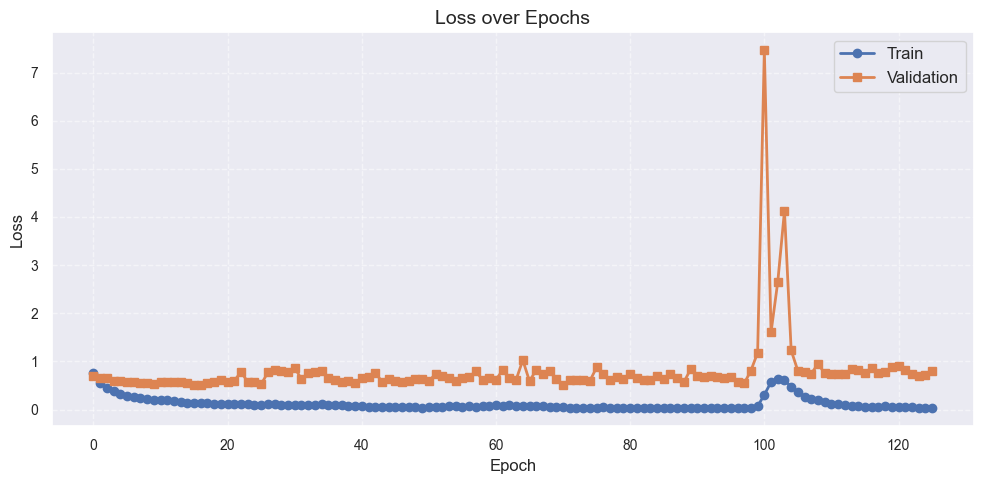

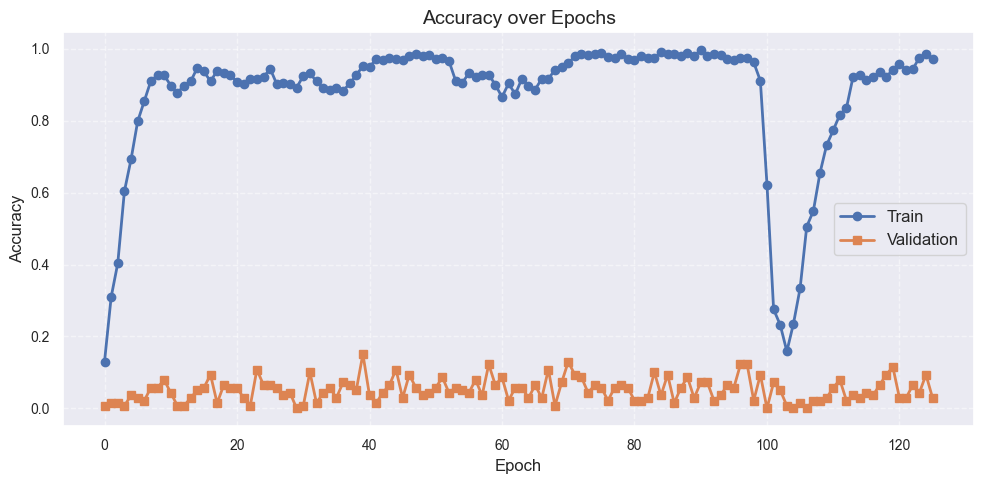

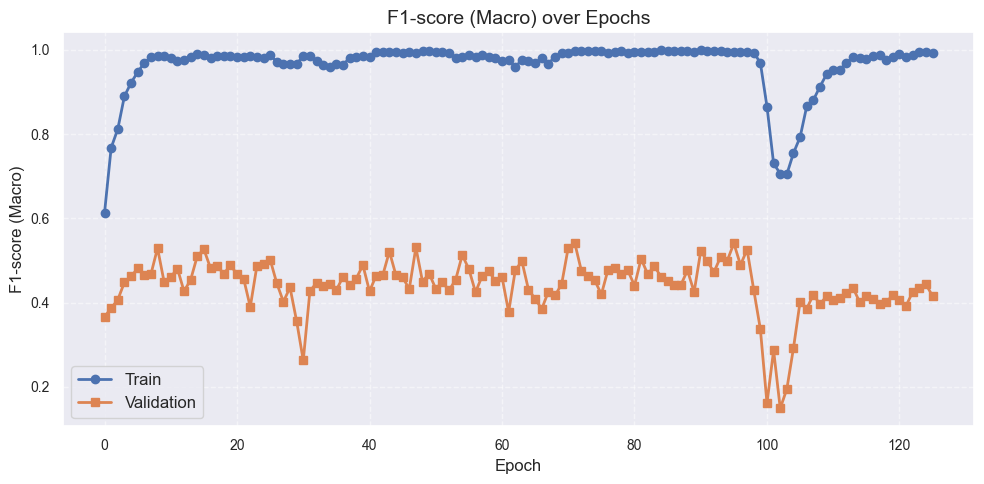

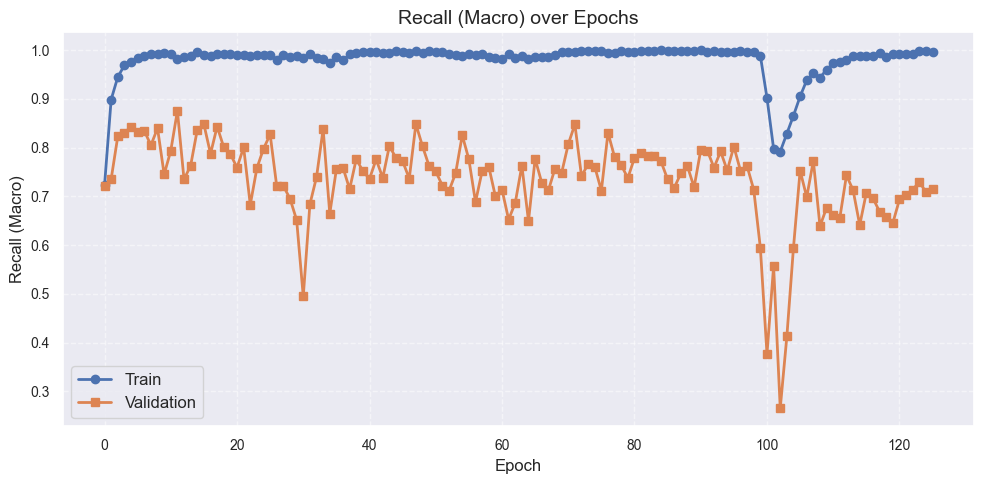

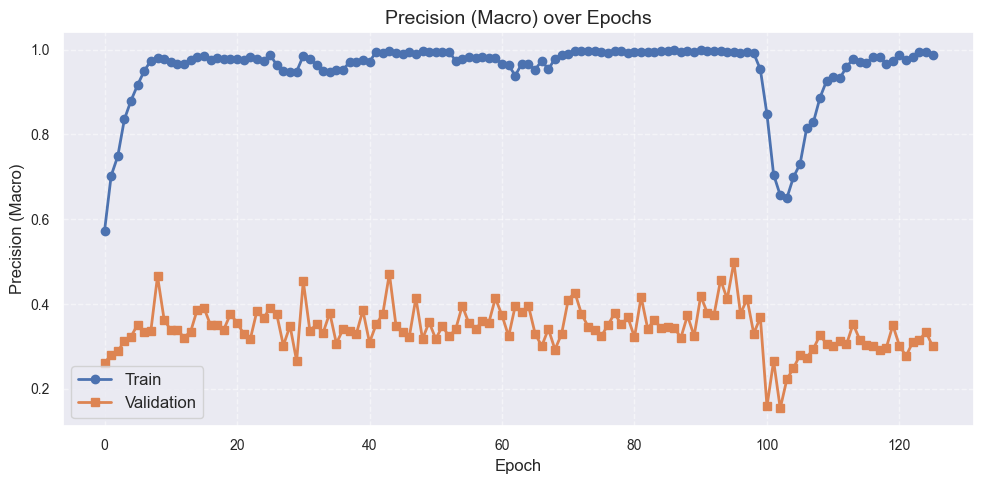

In [15]:
def plot_metric(metric_key, ylabel, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history[f"train_{metric_key}"], label="Train", linewidth=2, marker='o')
    plt.plot(history[f"val_{metric_key}"], label="Validation", linewidth=2, marker='s')
    plt.title(title, fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# 1) Loss
plot_metric("loss", "Loss", "Loss over Epochs")

# 2) Accuracy
plot_metric("accuracy", "Accuracy", "Accuracy over Epochs")

# 3) F1-score
plot_metric("f1", "F1-score (Macro)", "F1-score (Macro) over Epochs")

# 4) Recall
plot_metric("recall", "Recall (Macro)", "Recall (Macro) over Epochs")

# 5) Precision
plot_metric("precision", "Precision (Macro)", "Precision (Macro) over Epochs")
